## Plotting
In this .ipynb file, the way of plotting the accessed data.
If the following code is executed, then the accessed data is plotted.

The code need to be executed after Py4J GatewayServer is started in the way of [Start Py4 GatewayServer](../sample-usage.ipynb#Start-Py4J-GatewayServer).

### Preparation

In [1]:
# Initializes Java gateway to use Java code from Python program.
from py4j.java_gateway import JavaGateway
gateway = JavaGateway()

In [2]:
data_store = gateway.jvm.signdoubt.gisutil.store.InMemorySortedStore(gateway.jvm.java.util.TreeMap())
index_store = gateway.jvm.signdoubt.gisutil.store.AccessLoggingSortedStore()

In [3]:
# initialize handler of spatial query
config = gateway.jvm.signdoubt.gisutil.EasyConfig(
    gateway.jvm.scala.collection.immutable.Map.Map1('subspace.point.count.max', '4'))
query_handler = (gateway.jvm.signdoubt.gisutil.core.SpatialQueryHandlerFactory
                 .subSpaceAwareQueryHandler(data_store, index_store, config))

In [4]:
# define utilities
def point(x, y):
    return gateway.jvm.signdoubt.gisutil.RoundedPoint(r(x), r(y))

def rectangle(low_x, low_y, up_x, up_y):
    return gateway.jvm.signdoubt.gisutil.Rectangle(r(low_x), r(low_y), r(up_x), r(up_y))

def r(v):
    return int(v * 10000000)

m = 0b10000000000000000000000000000000 / 10000000

def restore(rectangle):
    def f(v):
        return float(v) / 10000000
    return (f(rectangle.lowerX()), f(rectangle.lowerY()), f(rectangle.upperX()), f(rectangle.upperY()))

def restore_point(rounded_point):
    def f(v):
        return float(v) / 10000000
    return (f(rounded_point.x()), f(rounded_point.y()))

In [5]:
import itertools
import numpy as np

# define sample data
np.random.seed(0)
xs = [135 + i for i in np.random.randn(100)]
ys = [35 + i for i in np.random.randn(100)]
zipped =  list(zip(xs, ys))

In [6]:
# matplotlib for plotting point
%matplotlib nbagg
import matplotlib.pyplot as plt
import seaborn as sns

### Plotting SubSpaces and inserted points

In [7]:
history = []
for x, y in zipped:
    query_handler.put(point(x, y), 'dummy data')

    patches = []
    itr = index_store.toIterable().iterator()
    while itr.hasNext():
        subspace = itr.next()._2()
        lower_x, lower_y, upper_x, upper_y = restore(subspace.rectangle())
        width = upper_x - lower_x
        height = upper_y - lower_y
        patches.append((lower_x, lower_y, width, height))
    history.append(patches)

<IPython.core.display.Javascript object>


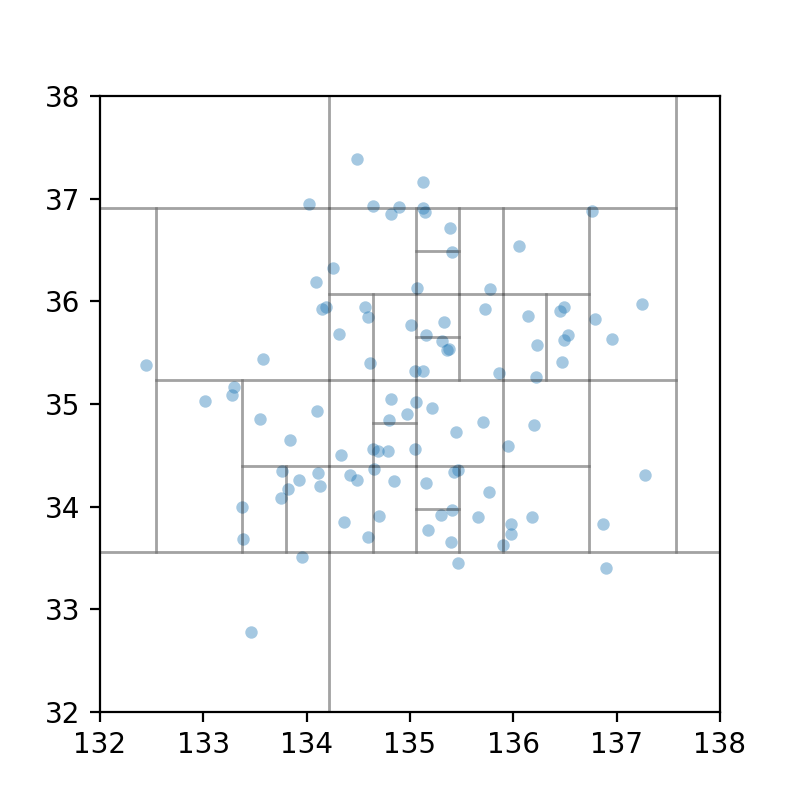

In [8]:
from matplotlib import pyplot as plt
from matplotlib import animation

fig, ax = plt.subplots(figsize=(4, 4))

def animate(i):
    ax.cla()
    ax.axis([132, 138, 32, 38])

    patches = []
    patches.append(ax.scatter(xs[:i], ys[:i], alpha=0.4, linewidths=0, s=20))
    for rectangle in history[i]:
        lower_x, lower_y, width, height = rectangle
        patches.append(ax.add_patch(plt.Rectangle((lower_x, lower_y), width, height, linewidth=1, fill=False, alpha=0.2)))
    return patches

anim = animation.FuncAnimation(fig, animate, frames=len(history), interval=100, blit=True, repeat=False)
plt.show()

### Plotting SubSpaces when range scan is executed

In [9]:
def extract_touched(itr):
    touched = []
    while itr.hasNext():
        sub_space = itr.next()._2().get()
        lower_x, lower_y, upper_x, upper_y = restore(sub_space.rectangle())
        width = upper_x - lower_x
        height = upper_y - lower_y
        touched.append((lower_x, lower_y, width, height))
    return touched
    
def prepare_touched(ax, touched, size):
    patches = []
    for i in range(size):
        lower_x, lower_y, width, height = touched[i]
        patches.append(ax.add_patch(plt.Rectangle((lower_x, lower_y), width, height, linewidth=1, fill=False, alpha=0.2)))
        patches.append(ax.text(lower_x, lower_y, '#' + str(i + 1), alpha=0.7, size='x-small'))
    return patches

In [10]:
# plotting SubSpaces for range scan
index_store.logger().clear()
rect = rectangle(135.5, 34.5, 136.5, 35.5)

lower_x, lower_y, upper_x, upper_y = restore(rect)
width = upper_x - lower_x
height = upper_y - lower_y
query_area = plt.Rectangle((lower_x, lower_y), width, height, linewidth=1, alpha=0.3)

query_handler.scan(rect)
itr = index_store.logger().iterator()
touched = extract_touched(itr)

<IPython.core.display.Javascript object>


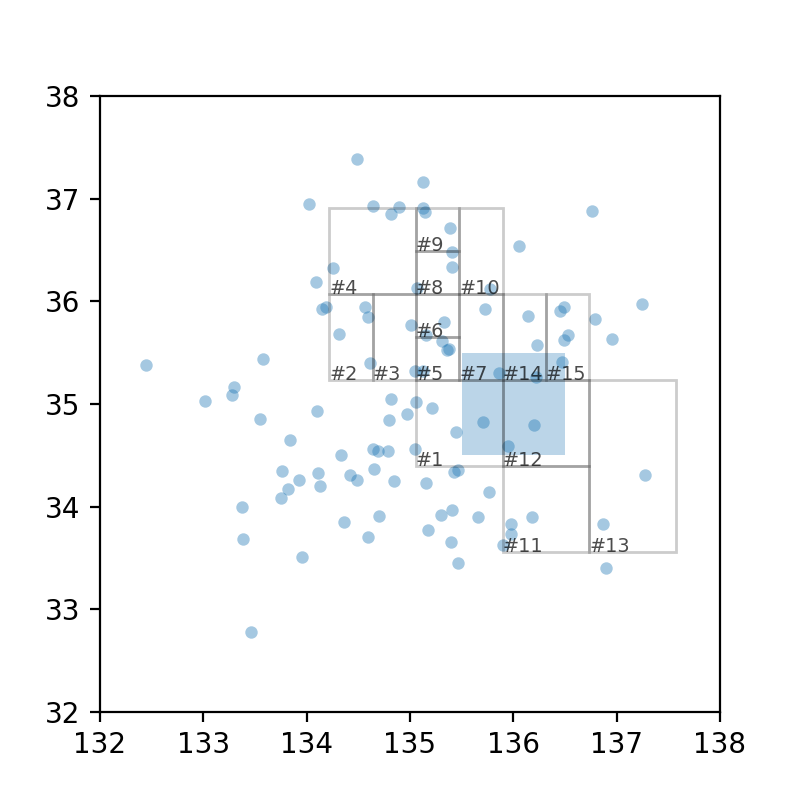

In [11]:
def animate(i):
    ax.cla()
    ax.axis([132, 138, 32, 38])
    patches = []
    patches.append(ax.scatter(xs, ys, alpha=0.4, linewidths=0, s=20))
    patches.append(ax.add_patch(query_area))
    patches += prepare_touched(ax, touched, i + 1)
    return patches

fig, ax = plt.subplots(figsize=(4, 4))
anim = animation.FuncAnimation(fig, animate, frames=len(touched), interval=100, blit=True, repeat=False)
plt.show()

### Plotting SubSpaces when nearest search is executed

In [12]:
index_store.logger().clear()

# search k-nearest neighbors
k = 6
base_point = (135.8, 35.8)
itr = query_handler.nearestNeighbor(point(base_point[0], base_point[1]), k).iterator()
knn = []
while (itr.hasNext()):
    knn.append(restore_point(itr.next()._1()))

# plot k-nearest neighbors
knn_x, knn_y = zip(*knn)

itr = index_store.logger().iterator()
touched = extract_touched(itr)

<IPython.core.display.Javascript object>


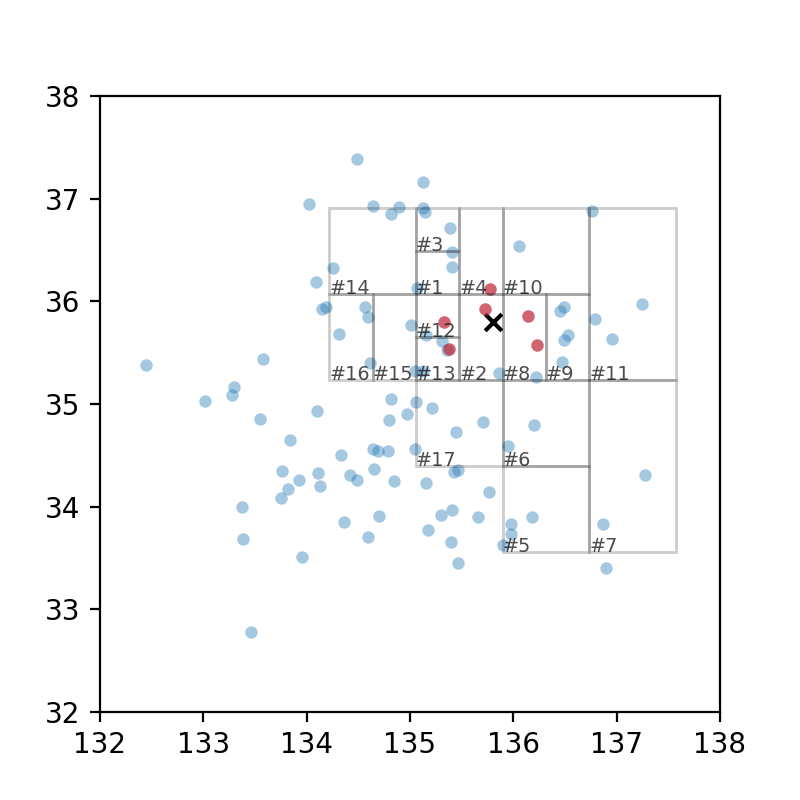

In [13]:
def animate(i):
    ax.cla()
    ax.axis([132, 138, 32, 38])

    patches = []
    patches.append(ax.scatter(base_point[0], base_point[1], c='black', marker='x', linewidths=2))
    patches.append(ax.scatter(xs, ys, alpha=0.4, linewidths=0, s=20))
    patches.append(ax.scatter(knn_x, knn_y, c='red', alpha=0.5, linewidths=0, s=20))

    patches += prepare_touched(ax, touched, i + 1)

fig, ax = plt.subplots(figsize=(4, 4))
anim = animation.FuncAnimation(fig, animate, frames=len(touched), interval=100, blit=True, repeat=False)
plt.show()